In [59]:
import torch.nn as nn
import torch.nn.functional as F
import torch

from torch.autograd import Variable
import torch.backends.cudnn as cudnn

from torchvision.utils import save_image

import numpy as np

import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader,Dataset
from torchvision import transforms, models, datasets
import glob

from PIL import Image

from pylab import imread,subplot,imshow,show

import matplotlib.pyplot as plt

import random

from torch.optim.lr_scheduler import LambdaLR, StepLR

In [36]:
for epoch in range (200):
  if (os.path.exists("./output/%03d" % epoch)) == False:
    os.mkdir("./output/%03d" % epoch)
  else:
    files = glob.glob("./output/%03d/*.png" % epoch)

    for f in files:
      os.remove(f)

# Data

In [37]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

kwargs = {'num_workers': 2, 'pin_memory': True}

cuda = True
image_size = 32
batchSize = 16

In [38]:
def show_img(source, target, source_label, target_label):
    num_row = 4
    num_col = 5
    num = 10
    images = source[:num]
    labels = source_label[:num]

    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
    for i in range(num):
        ax = axes[i//num_col, i%num_col]
        
        image =  images[i].transpose(0,2).transpose(0,1)

        ax.imshow(image, cmap='gray')
        ax.set_title('Label: {}'.format(labels[i]))


    images = target[:num]
    labels = target_label[:num]
    for i in range(10,20):
        ax = axes[i//num_col, i%num_col]
        image = images[i - 10].transpose(0,2).transpose(0,1)
        ax.imshow(image, cmap='gray')
        ax.set_title('Label: {}'.format(labels[i - 10]))
    plt.tight_layout()
    plt.show()

## Mnist

In [39]:
transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.Grayscale(3),
        transforms.ToTensor(),
        transforms.Lambda(lambda t: t * 2 - 1)])

mnist_trainset = datasets.MNIST(root='./data/mnist', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data/mnist', train=False, download=True, transform=transform)


## Mnist-M

In [40]:
def get_backgrounds():
    backgrounds = []
    for file in os.listdir("./images/train"):
        if file.endswith('.jpg'):
            backgrounds.append(plt.imread(os.path.join("./images/train",file)))
    return backgrounds

def compose_image(image, backgrounds):
    image = (image > 0).astype(np.float32)
    image = image.reshape([28,28])*255.0
    
    image = np.stack([image,image,image],axis=2)
    
    background = np.random.choice(backgrounds)
    w,h,_ = background.shape
    dw, dh,_ = image.shape
    x = np.random.randint(0,w-dw)
    y = np.random.randint(0,h-dh)
    
    temp = background[x:x+dw, y:y+dh]
    return np.abs(temp-image).astype(np.uint8)

class MNISTM(Dataset):    
    def __init__(self, train=True,transform=None):
        if train:
            self.data = datasets.MNIST(root='.data/mnist',train=True, download=True)
        else:
            self.data = datasets.MNIST(root='.data/mnist',train=False, download=True)
        self.backgrounds = get_backgrounds()
        self.transform = transform
        self.images = []
        self.targets = []
        for index in range(len(self.data)):
            image = np.array(self.data.__getitem__(index)[0])
            target = self.data.__getitem__(index)[1]
            image = compose_image(image, self.backgrounds)
            if self.transform is not None:
                image = self.transform(image)
            self.images.append(image)
            self.targets.append(target)
        
    def __getitem__(self,index):
        image = self.images[index]
        target = self.targets[index]
        
        return image, target
        
    def __len__(self):
        return len(self.data)

In [41]:
transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Lambda(lambda t: t * 2 - 1)
        ])

trainset = MNISTM(train=True,transform=transform)
testset = MNISTM(train=False,transform=transform)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [42]:
source_train = DataLoader(mnist_trainset, batch_size=batchSize, shuffle=True, drop_last=True, **kwargs)
source_test = DataLoader(mnist_testset, batch_size=batchSize, shuffle=True, drop_last=True, **kwargs)

In [43]:
target_train = DataLoader(trainset, batch_size=batchSize, shuffle=True, drop_last=True, **kwargs)
target_test = DataLoader(testset, batch_size=batchSize, shuffle=False, drop_last=True, **kwargs)

In [44]:
source_iter = iter(source_train)
source_inputs, source_label = source_iter.next()

target_iter = iter(target_train)
target_inputs, target_label = target_iter.next()

In [45]:
print("%2f, %2f" % (torch.min(source_inputs), torch.max(source_inputs)))

-1.000000, 1.000000


In [46]:
print("%2f, %2f" % (torch.min(target_inputs), torch.max(target_inputs)))

-1.000000, 1.000000


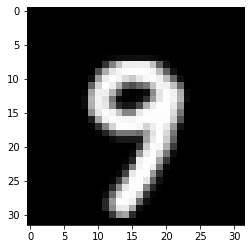

In [47]:
index = random.randint(0, 15)
image_source_sample = source_inputs[index]
image_source_sample = (image_source_sample + 1) * 0.5
image = image_source_sample.transpose(0,2).transpose(0,1)
plt.imshow(image)

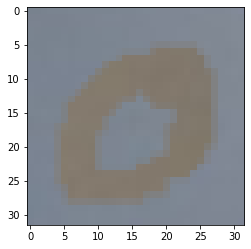

In [48]:
image_target_sample = target_inputs[index]
image_target_sample = (image_target_sample + 1) * 0.5
image = image_target_sample.transpose(0,2).transpose(0,1)
plt.imshow(image)

# Module

## Perceptual

In [49]:
class Perceptual(nn.Module):
    def __init__(self):
        super(Perceptual, self).__init__()

        self.encoder = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(3, 64, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ReflectionPad2d(3),
            nn.Conv2d(64, 3, 7),
            nn.InstanceNorm2d(3),
            nn.Tanh()
        )

    def forward(self, A, B):
        encode_A = self.encoder(A)
        encode_B = self.encoder(B)
        reconA = self.decoder(encode_A)
        reconB = self.decoder(encode_B)

        encode_A.detach()
        encode_B.detach()

        style = encode_A[:, 0:128, : , :]
        content = encode_B[:, 128:256, :, :]
        
        mixed_latent = torch.cat([style, content], dim=1)
        mixed_image = self.decoder(mixed_latent)

        return mixed_image, reconA, reconB

In [50]:
test_tensor_source = source_inputs
test_tensor_target = target_inputs

perceptual = Perceptual()
encoder = perceptual.encoder
decoder = perceptual.decoder
encoder_out = encoder(test_tensor_target)
decoder_out = decoder(encoder_out)

print(encoder_out.size())
print(decoder_out.size())

mixed, reconA, reconB = perceptual(test_tensor_source, test_tensor_target)
print(mixed.size())
print(reconA.size())
print(reconB.size())

print("mixed: min: %.2f, max: %.2f " % (torch.min(mixed), torch.max(mixed)))

print("reconA: min: %.2f, max: %.2f " % (torch.min(reconA), torch.max(reconA)))

print("reconB: min: %.2f, max: %.2f " % (torch.min(reconB), torch.max(reconB)))

torch.Size([16, 256, 8, 8])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
mixed: min: -1.00, max: 1.00 
reconA: min: -1.00, max: 1.00 
reconB: min: -1.00, max: 1.00 


In [51]:
print(mixed[0][0][0] - reconA[0][0][0])
print(mixed[0][0][0] - reconB[0][0][0])

tensor([ 0.0099,  0.3845, -0.1854, -0.8284,  0.0756,  0.1412, -0.1317,  0.3071,
         0.7307,  0.3407, -0.3687,  0.0293,  0.2705,  0.7862, -0.4630, -0.6915,
         0.8435,  0.1458,  0.4327, -0.4140, -0.5035,  0.0301,  0.1885,  0.1583,
         0.3218,  0.4494,  0.2259,  0.0106,  0.3904,  0.5153,  0.1561,  0.3694],
       grad_fn=<SubBackward0>)
tensor([-0.3743,  0.6743, -0.7067, -0.1883,  0.2838, -0.4856, -0.4541, -0.1170,
         0.6849,  0.6962, -0.9130,  0.3464,  0.0800,  0.3866, -0.4016, -0.3656,
        -0.4752, -0.1715,  1.0259, -0.3761, -0.2827, -0.0826, -0.1782,  0.0661,
        -0.4575, -0.2132, -0.0700,  0.3756,  0.2064,  0.2126, -0.2967, -0.0246],
       grad_fn=<SubBackward0>)


## Discriminator

In [52]:
class Discriminator(nn.Module):
    def __init__(self, input_nc = 3):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(input_nc, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, padding=1),
            nn.InstanceNorm2d(128), 
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, padding=1),
            nn.InstanceNorm2d(256), 
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 1, 4, padding=1)
        )


    def forward(self, x):
        x =  self.model(x)
        return F.avg_pool2d(x, x.size()[2:]).view(x.size()[0], -1)

In [53]:
discriminator = Discriminator()

output = discriminator(test_tensor_source)
print(output.size())
print(torch.min(output))
print(torch.max(output))

torch.Size([16, 1])
tensor(0.1058, grad_fn=<MinBackward1>)
tensor(0.1290, grad_fn=<MaxBackward1>)


# Loss

In [54]:
def tv_loss(img, tv_weight=5e-2):
    w_variance = torch.sum(torch.pow(img[:,:,:,:-1] - img[:,:,:,1:], 2))
    h_variance = torch.sum(torch.pow(img[:,:,:-1,:] - img[:,:,1:,:], 2))
    loss = tv_weight * (h_variance + w_variance)
    return loss

def total_variation_loss(img, weight=5e-2):
    bs_img, c_img, h_img, w_img = img.size()
    tv_h = torch.pow(img[:, :, 1:, :] - img[:, :, :-1, :], 2).sum()
    tv_w = torch.pow(img[:, :, :, 1:] - img[:, :, :, :-1], 2).sum()
    return weight * (tv_h + tv_w) / (bs_img * c_img * h_img * w_img)

def compute_content_loss(target_feature, content_feature):
    return torch.mean((target_feature - content_feature)**2)

def batch_gram_matrix(img):
    b, d, h, w = img.size()
    img = img.view(b*d, h*w)
    gram = torch.mm(img, img.t())
    return gram
    
style_weights = {'conv1_1': 1.0, 'conv2_1': 0.75, 'conv3_1': 0.2, 'conv4_1': 0.2, 'conv5_1': 0.2}

def compute_style_loss(style_features, target_features):
    style_loss = 0
    style_grams = {layer: batch_gram_matrix(style_features[layer]) for layer in style_features}

    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = batch_gram_matrix(target_feature)
        _, d, h, w = target_feature.shape

        style_gram = style_grams[layer]

        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram) ** 2)
        style_loss += layer_style_loss / (d * h * w)

    return style_loss

# Training

## Training Method

In [55]:
def get_features(image, model, layers=None):
    if layers is None:
        layers = {'0': 'conv1_1', 
              '3': 'conv2_1', 
              '6': 'conv3_1', 
              '11': 'conv4_1',
              '13': 'conv4_2', 
              '16': 'conv5_1'}
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x

    return features

## Model hypermeter

In [56]:
perceptual = Perceptual()
discriminator = Discriminator()

In [60]:
learning_rate = 0.05
beta = (0.5, 0.999)

criterion_adv = torch.nn.MSELoss()
criterion_discriminator = torch.nn.MSELoss()
criterion_construct = torch.nn.L1Loss()

optimizer_pre = torch.optim.Adam(perceptual.parameters(), lr=learning_rate, betas=beta)
optimizer_dis = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=beta)

scheduler_pre = StepLR(optimizer_pre, step_size=40, gamma=0.4)
scheduler_dis = StepLR(optimizer_dis, step_size=40, gamma=0.4)

In [61]:
vgg = models.vgg11(pretrained=True).features
for param in vgg.parameters():
    param.requires_grad_(False)

Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth


  0%|          | 0.00/507M [00:00<?, ?B/s]

In [62]:
if (torch.cuda.is_available()):
    torch.cuda.manual_seed_all(42)
    cudnn.benchmark = True

    criterion_construct = criterion_construct.cuda()
    criterion_discriminator = criterion_discriminator.cuda()
    criterion_construct = criterion_construct.cuda()

    vgg.cuda()
    perceptual.cuda()
    discriminator.cuda()

## Init the network

In [63]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant(m.bias.data, 0.0)

In [64]:
perceptual.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

## Training

In [ ]:
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

real_label = Variable(Tensor(batchSize).fill_(1.0), requires_grad=False)
fake_label = Variable(Tensor(batchSize).fill_(0.0), requires_grad=False)
real_label = real_label[:, None]
fake_label = fake_label[:, None]


input_A = Tensor(batchSize, 3, image_size, image_size)
input_B = Tensor(batchSize, 3, image_size, image_size)

for epoch in range(0, 200):
    i = -1
    for batchA, batchB in zip(target_train, source_train):
        i+= 1
        real_A = Variable(input_A.copy_(batchA[0]))
        real_B = Variable(input_B.copy_(batchB[0]))

        optimizer_pre.zero_grad()
        mixed_image, reconstructionA, reconstructionB = perceptual(real_A, real_B)

        loss_ss = criterion_construct(reconstructionA, real_A) * 15.0
        loss_tt = criterion_construct(reconstructionB, real_B) * 15.0

        TV_loss = total_variation_loss(mixed_image)
        pred_fake = discriminator(mixed_image)
        loss_adv = criterion_adv(pred_fake, real_label)

        cuda_mixed_image = mixed_image.clone().requires_grad_(True).cuda()
        cuda_real_A = real_A.clone().requires_grad_(True).cuda()
        cuda_real_B = real_B.clone().requires_grad_(True).cuda()
        style_features = get_features(cuda_real_A, vgg)
        content_features = get_features(cuda_real_B, vgg)
        target_features = get_features(cuda_mixed_image, vgg)

        content_loss = compute_content_loss(target_features['conv4_2'], content_features['conv4_2']) * 0.1
        style_loss = compute_style_loss(style_features, target_features) * 0.05

        preceptual_loss = loss_ss + loss_tt + TV_loss + loss_adv + content_loss + style_loss

        preceptual_loss.backward()
        optimizer_pre.step()

        optimizer_dis.zero_grad()

        pred_real = discriminator(real_A)
        pred_fake = discriminator(mixed_image.detach())

        loss_dis_real = criterion_discriminator(pred_real, real_label)
        loss_dis_fake = criterion_discriminator(pred_fake, fake_label)

        discriminator_loss = loss_dis_real + loss_dis_fake
        discriminator_loss.backward()
        optimizer_dis.step()

        if  i % 200 == 0:
            real_A = real_A.data
            real_B = real_B.data
            mixed_image = mixed_image.data
            reconstructionA = reconstructionA.data
            reconstructionB = reconstructionB.data

            save_image(real_A, './output/%03d/%d_A.png' % ( epoch, i))
            save_image(real_B, 'output/%03d/%d_B.png' % ( epoch, i))
            save_image(reconstructionA, 'output/%03d/%d_reconA.png' % ( epoch, i))
            save_image(reconstructionB, 'output/%03d/%d_reconB.png' % ( epoch, i))
            save_image(mixed_image, 'output/%03d/%d_Mixed.png' % ( epoch, i))

    print ("e: %d" % epoch)    
    print ("pre_loss: %.2f, loss_ss: %.2f, loss_tt: %.2f, loss_adv: %.2f, content: %.2f, style: %.2f" % (preceptual_loss, loss_ss, loss_tt, loss_adv, content_loss, style_loss))
    print ("discriminator_loss: %.2f, D_real: %.2f, D_fake: %.2f" % (discriminator_loss, loss_dis_real, loss_dis_fake))

    scheduler_pre.step()
    scheduler_dis.step()
    

e: 0
pre_loss: 22.83, loss_ss: 8.04, loss_tt: 13.01, loss_adv: 1.33, content: 0.33, style: 0.10
discriminator_loss: 8.39, D_real: 2.22, D_fake: 6.17
e: 1
pre_loss: 25.10, loss_ss: 9.33, loss_tt: 13.38, loss_adv: 0.96, content: 0.56, style: 0.83
discriminator_loss: 2.85, D_real: 1.56, D_fake: 1.29
e: 2
pre_loss: 28.24, loss_ss: 7.51, loss_tt: 11.19, loss_adv: 9.00, content: 0.45, style: 0.05
discriminator_loss: 17.18, D_real: 5.72, D_fake: 11.46
e: 3
pre_loss: 24.09, loss_ss: 9.65, loss_tt: 13.99, loss_adv: 0.06, content: 0.30, style: 0.02
discriminator_loss: 0.71, D_real: 0.33, D_fake: 0.38
e: 4
pre_loss: 17.24, loss_ss: 6.39, loss_tt: 9.95, loss_adv: 0.41, content: 0.39, style: 0.05
discriminator_loss: 0.54, D_real: 0.39, D_fake: 0.15
e: 5
pre_loss: 27.93, loss_ss: 6.68, loss_tt: 11.77, loss_adv: 8.91, content: 0.38, style: 0.12
discriminator_loss: 23.12, D_real: 8.20, D_fake: 14.92
e: 6
pre_loss: 22.02, loss_ss: 8.42, loss_tt: 13.16, loss_adv: 0.04, content: 0.29, style: 0.01
discrim

In [ ]:
torch.save(perceptual, "./model_weight/perceptual")
torch.save(discriminator, "./model_weight/discriminator")

# Resulting image

In [ ]:
image = imread('./output/199/00_400_Mixed.png')

plt.imshow(image)

In [ ]:
image = imread('./output/199/00_400_reconB.png')

plt.imshow(image)